In [1]:
import sys
sys.path.append('/Users/clairewest/Cambridge/research/codes/photothermal_imaging/analytic')
from analytic_psfs_p2 import Mie_Theory as mie_new
from analytic_psfs_p2 import Photothermal_Image as pt_new

from old_analytic_psfs import Mie_Theory as mie_old
from old_analytic_psfs import Photothermal_Image as pt_old

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelpad'] = 0.0
plt.rcParams['xtick.major.pad']='2'
plt.rcParams['ytick.major.pad']='2'

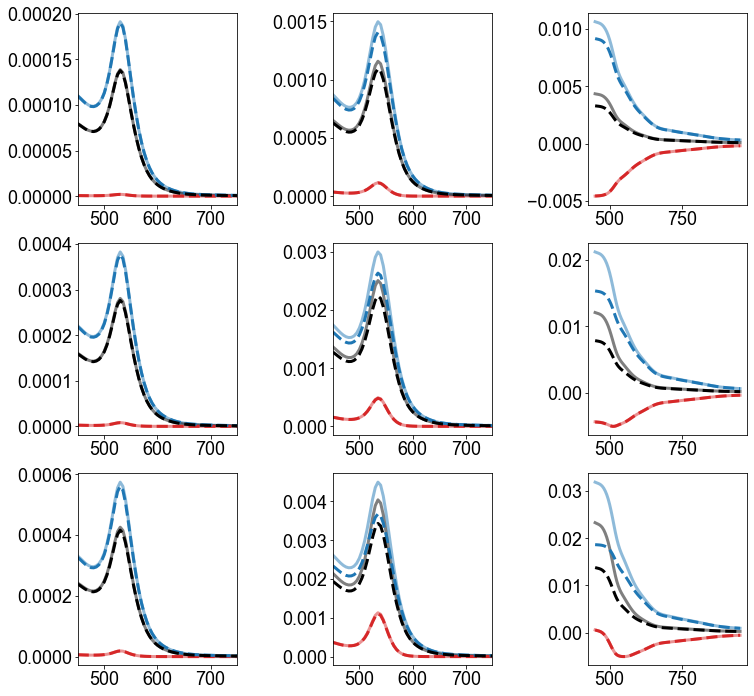

In [2]:
fig, ax = plt.subplots(3, 3, figsize=[12,12])

radius_all = np.array([10, 20, 75])*1E-7

nTOT=1
pump_power_all = np.array([100, 200, 300])*10 # #uW -> cgs units
nb=1.473
wave_pump = np.round(np.arange(450, 951, 5)*1E-7, 7)
wave_probe = np.array([785.E-7])

delta_z = np.array([ 3.e-05 , 3.e-05 , 3e-05])
zprobe_focus = np.array([ 3.e-05 , 3.e-05 , 3.e-05 ])



phi_scas = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump)))
phi_ints = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump)))
phi_scac = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump)))
phi_intc = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump)))


waist = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump)))

for idxp, valp in enumerate(pump_power_all):
    for idxr, valr in enumerate(radius_all):
        for idxw, valw in enumerate(wave_pump):
            pump_power = valp
            mt = mie_old(radius=valr, nb=nb, selected_waves=valw)
            mie_abs_tot, mie_sca_tot, _ = mt.cross_sects(nTOT=nTOT)
            pt = pt_old(radius=valr, wave_pump=valw,
                                    abs_cross=mie_abs_tot, P0h=pump_power, 
                                    wave_probe=wave_probe,nb_T0=nb, dnjdT='constant', 
                                    delta_z=delta_z[idxr], zprobe_focus=zprobe_focus[idxr])

            phi_ints[idxp, idxr, idxw], phi_scas[idxp, idxr, idxw], waist[idxp, idxr, idxw] = pt.pt_signal('sin')
            phi_intc[idxp, idxr, idxw], phi_scac[idxp, idxr, idxw], _ = pt.pt_signal('cos')
            
            
        old_int = phi_ints[idxp, idxr, :] + phi_intc[idxp, idxr, :]
        old_sca = phi_scas[idxp, idxr, :] + phi_scac[idxp, idxr, :]
        old_tot = np.sqrt( (phi_ints[idxp, idxr, :] + phi_scas[idxp, idxr, :])**2
                          + (phi_intc[idxp, idxr, :] + phi_scac[idxp, idxr, :])**2 )
            
            
        wpu_np = waist[idxp, idxr, idxw]*1E4
        ax[idxp, idxr].plot(wave_pump*1E7, old_sca*wpu_np**2, color='tab:red',alpha=0.5)
        ax[idxp, idxr].plot(wave_pump*1E7, old_int*wpu_np**2,color='tab:blue',alpha=0.5)
        ax[idxp, idxr].plot(wave_pump*1E7, old_tot*wpu_np**2, color='black',alpha=0.5)


#########################################################
######################## New Way ########################
#########################################################

order = 'second'
wave_probe = 785.E-7
delta_z = 3.e-05
zprobe_focus = 3.e-05

phi_sca = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump), 2))
phi_int = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump), 2))
waist = np.zeros((len(pump_power_all), len(radius_all), len(wave_pump)))

mie_abs_tot = np.zeros((len(radius_all), len(wave_pump)))
mie_sca_tot = np.zeros((len(radius_all), len(wave_pump)))

for idxp, valp in enumerate(pump_power_all):
    for idxr, valr in enumerate(radius_all):
        for idxw, valw in enumerate(wave_pump):
            mt = mie_new(radius=valr, 
                            nb=nb, 
                            wave=valw,
                            drude_or_jc='jc')
            mie_abs_tot[idxr, idxw], mie_sca_tot[idxr, idxw] = mt.cross_sects(nTOT=nTOT)

            pt = pt_new(radius=valr,
                        wave_pump=valw,
                        abs_cross=mie_abs_tot[idxr, idxw],
                        P0h=valp, 
                        wave_pr=wave_probe,
                        nb_T0=nb, 
                        delta_z=delta_z,
                        zprobe_focus=zprobe_focus,
                        order=order)
            
            phi_int[idxp, idxr, idxw,:], phi_sca[idxp, idxr, idxw,:], waist[idxp, idxr, idxw] = pt.pt_signal()
        wpu_np = waist[idxp, idxr, idxw]*1E4
        
        new_int =  np.sum(phi_int[idxp, idxr, :, :], axis=-1)
        new_sca =  np.sum(phi_sca[idxp, idxr, :, :], axis=-1)
        
        new_tot = np.sqrt((phi_int[idxp, idxr, :, 0] + phi_sca[idxp, idxr, :, 0])**2
                              + (phi_int[idxp, idxr, :, 1] + phi_sca[idxp, idxr, :, 1])**2)
        
        
        ax[idxp, idxr].plot(wave_pump*1E7, new_sca*wpu_np**2, color='tab:red',alpha=1, linestyle='--')
        ax[idxp, idxr].plot(wave_pump*1E7, new_int*wpu_np**2,color='tab:blue',alpha=1, linestyle='--')
        ax[idxp, idxr].plot(wave_pump*1E7, new_tot*wpu_np**2, color='black',alpha=1, linestyle='--')
        
ax[0,0].set_xlim([450,750]); ax[1,0].set_xlim([450,750]); ax[2,0].set_xlim([450,750])
ax[0,1].set_xlim([450,750]); ax[1,1].set_xlim([450,750]); ax[2,1].set_xlim([450,750])

fig.subplots_adjust(wspace=.6)